# Modelo de optimización MILP inscripción a cursada (simplificado):
---
- Autor: **[Rodrigo Maranzana](https://www.linkedin.com/in/rodrigo-maranzana/)**
- Año: **2020**
- Licencia: **[MIT License](https://github.com/harb-OR/casos_practicos/blob/master/LICENSE)**
---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introducción:" data-toc-modified-id="Introducción:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introducción:</a></span></li><li><span><a href="#Información-inicial:" data-toc-modified-id="Información-inicial:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Información inicial:</a></span></li><li><span><a href="#Modelo-de-optimización-entero-mixto-(MILP):" data-toc-modified-id="Modelo-de-optimización-entero-mixto-(MILP):-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modelo de optimización entero mixto (MILP):</a></span><ul class="toc-item"><li><span><a href="#Parámetros:" data-toc-modified-id="Parámetros:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Parámetros:</a></span></li><li><span><a href="#Definimos-los-sets-y-variables:" data-toc-modified-id="Definimos-los-sets-y-variables:-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Definimos los sets y variables:</a></span></li><li><span><a href="#Función-objetivo" data-toc-modified-id="Función-objetivo-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Función objetivo</a></span></li><li><span><a href="#Restricciones:" data-toc-modified-id="Restricciones:-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Restricciones:</a></span></li><li><span><a href="#Resolución-del-modelo-y-resultados:" data-toc-modified-id="Resolución-del-modelo-y-resultados:-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Resolución del modelo y resultados:</a></span></li></ul></li><li><span><a href="#Gráfico-de-horarios:" data-toc-modified-id="Gráfico-de-horarios:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Gráfico de horarios:</a></span></li></ul></div>

## Introducción:
Se propone realizar un modelo de optimización entero mixto para la asignación de alumnos a cursos de la facultad. Se describe, la información inicial, generación de parámetros, el modelo matemático y la resolución computacional. La librería PuLP de Python es la elegida para resolver el modelo.
Siendo que el tamaño del problema y su complejidad es baja, no es costoso resolverlo y por lo tanto puede ser hecho mediante esta clase de optimización.
Se recomienda buscar alternativas heurísticas o híbridas (MILP + heurística) en caso de complejizar el presente modelo.

Las suposiciones del modelo son las siguientes:
- El sistema de inscripción no tiene alternativas. El alumno selecciona todas las materias a las que quiere inscribirse y el sistema, mediante optimización del conjunto total de alumnos devuelve en cuáles quedó anotado.
- No existen cátedras, hay $n$ materias a las cuales los alumnos se inscriben.
- Existe un cupo para cada curso.
- Una materia puede tener varios bloques de cursada (ej: lunes y viernes) y cada uno ocupar una cantidad determinada de módulos (ej: tres módulos por bloque). Los bloques asignados a una materia particular tienen la misma cantidad de módulos.
- Los módulos son independientes entre sí, no existe la superposición de horarios entre distintos módulos.
- Los alumnos que compiten por entrar a la misma materia serán únicamente seleccionados según su peso académico, según la misma fórmula que utiliza la Universidad Tecnológica Nacional FRBA.

*Nota: este ejemplo es solamente a modo didáctico y está resuelto de esta manera para mostrar la formulación y resolución de un modelo de optimización. Es válido pensar que puede resolverse de manera heurística mucho más simple de lo que implica un modelo MILP. Por lo tanto, dadas las simplificaciones una heurística de tipo cascada que inscriba alumnos secuencialmente ordenados por su peso académico. Sin embargo, el objetivo es, como se dijo anteriormente, la explicación didáctica del modelo y brindar un puntapié inicial para modificaciones que lo hagan más complejo y anulen la posibilidad de la heurística de cascada.

In [215]:
import pulp
import numpy.random as rnd
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Información inicial:
Se nos presenta la siguiente información:
- número de materias,
- número de alumnos,
- número total de módulos por semana,
- parámetro alfa para tiempo de cursada,
- parámetro beta para tiempo de cursada,
- parámetro n para tiempo de cursada,
- parámetro n para materias aprobadas,
- parámetro p para materias aprobadas,
- parametro n para materias desaprobadas,
- parámetro p para materias desaprobadas,
- parametro n para inscripción a materias,
- parámetro p para inscripción a materias,

*Nota 1: Los parámetros de media y desvío estándar son para crear un dataset ficticio de alumnos. En el caso de una aplicación real, esto no sería estadístico y se usaría el dataset correspondiente del sistema de inscripción académico.*

*Nota 2: El número de módulos es una respresentación lineal de los módulos semanales. En este caso se considera que hay 12 módulos por día, y cinco días en una semana académica. Es decir que el módulo 13, es el primer módulo que se dicta el martes.*

In [216]:
num_materias = 40 # número de materias en juego.
num_alumnos = 500 # número total de alumnos.
num_modulos = 60 # número de módulo semanales.
min_cupo = 25 # mínimo valor de cupo en un curso.
max_cupo = 50 # máximo valor de cupo en un curso.
# Tiempo de cursada:
alfa_t_cursada = 0.7 # parámetro alfa beta-binomial.
beta_t_cursada = 2 # parámetro alfa beta-binomial.
n_t_cursada = 7 # parámetro n beta-binomial.
# Materias aprobadas (se supone dependiente del tiempo de cursada):
n_aprobadas = 8 # parámetro n binomial.
p_aprobadas = 0.7 # parámetro p binomial.
# Materias desaprobadas (se supone dependiente del tiempo de cursada):
n_desaprobadas = 2 # parámetro n binomial.
p_desaprobadas = 0.3 # parámetro p binomial.
# Cantidad de materias a la que se inscriben los alumnos:
n_inscripcion = 8 # parámetro n binomial.
p_inscripcion = 0.75 # parámetro p binomial.

## Modelo de optimización entero mixto (MILP):
Creamos un modelo de optimización MILP con la librería PuLP.

In [217]:
lp = pulp.LpProblem("matching_cursos", pulp.LpMaximize)

### Parámetros:

1) **Peso académico $peso_a$:** vector con los pesos que se le asigna a cada alumno para darle prioridad de inscripción frente a otros. La fórmula que se usa está descripta en el siguiente documento de inscripción: http://siga.frba.utn.edu.ar/up/docs/preinsweb.pdf y es la siguiente:

$$ PESO = 11*CMA - 5*AA - 3*CMD $$ 

Siendo $CMA$, la cantidad de materias aprobadas, $AA$, los años de antigüedad en la facultad y $CMD$, la cantidad de materias desaprobadas
Creamos tres vectores con datos ficticios de alumnos para $CMA$, $AA$ y $CMD$.

Dado que no tenemos datasets reales de información de alumnos, los recreamos mediante sampleos con el siguiente procedimiento:
- Se calcula el vector de antigüedad por cada alumno. El dataset tiene en cuenta que el tiempo total de cada alumno en la facultad es una variable aleatoria que sigue una distribución beta binomial: $T_a \sim \beta bin(\alpha,\beta,n)$. Se eligió esta distribución porque es sabido que hay mayor cantidad de alumnos en primeros años que en los últimos.
- Se calcula el vector de materias aprobadas. Se asume que se puede cursar un máximo de materias por año. Dado el tiempo que el alumno estuvo en la facultad, la cantidad de materias aprobadas se considera una variable aleatoria que siguen una distribución binomial: $Qap_a \sim B(n,p)$
- El cálculo del vector de materias desaprobadas es igual al de aprobadas. Es una variable aleatoria que sigue una distribución binomial: $Qde_a \sim B(n,p)$
- Se calcula el peso académico con la fórmula antes definida.

Es importante aclarar que para los sampleos de la cantidad de materias aprobadas y desaprobadas, el tiempo que el alumno pasó en la facultad incide en el valor de la variable aleatoria. Por ejemplo, para el caso de las materias aprobadas, suponiendo que el alumno estuvo dos años en la facultad, existe una variable aleatoria para el primer año $Qap_{a}^{1ero}$ y para el segundo $Qap_{a}^{2do}$. La cantidad total aprobada sería $Qap_{a}^{tot} = Qap_{a}^{1ero} + Qap_{a}^{2do}$.

Como cada variable sigue la distribución binomial con el parámetro $p$ igual, sabemos que en la suma de binomiales se cumple: $Qap_{a}^{tot} \sim B(n_1 + n_2, p)$. Pero además, dijimos que el parámetro $n$ es igual para todos los años, por lo tanto, el parámetro $n_{tot} = (T_a + 1) * n$. Recordemos que $T_a$ es la variable aleatoria que respresenta los años que pasó el alumno en la facultad.

Resumiendo, el sampleo de la variable se especifica como: $Qap_{a}^{tot} \sim B(n_{tot}, p)$

Por último, se debe controlar que la variable aleatoria no supere el número máximo de materias en la facultad. Es decir, establecer una cota máxima igual a la cantidad total de materias.

In [218]:
def beta_binomial(alfa, beta, n, size=None):
    p = np.random.beta(alfa, beta, size=size)
    sample = np.random.binomial(n, p)
    return sample

# Cálculo de peso académico:
# Años de antiguedad en la facultad:
aa_vector = beta_binomial(alfa_t_cursada, beta_t_cursada, n_t_cursada, size = num_alumnos)

# Cantidad de materias aprobadas:
n_aprobadas_vector = (aa_vector + 1) * n_aprobadas # calcular el n total
cma_vector = rnd.binomial(n_aprobadas_vector, p_aprobadas) # samplear
cma_vector = np.clip(cma_vector, 0, num_materias) # Evitar que haya alumnos con más materias aprobadas que totales.

# # Cantidad de materias desaprobadas:
n_desaprobadas_vector = (aa_vector + 1) * n_desaprobadas # calcular el n total
cmd_vector = rnd.binomial(n_desaprobadas_vector, p_desaprobadas) # samplear
cmd_vector = np.clip(cmd_vector, 0, num_materias) # Evitar que haya alumnos con más materias aprobadas que totales.

# Vector de peso académico:
peso_alumno = 11 * cma_vector - 5 * aa_vector - 3 * cmd_vector

# Print de los primeros 10 valores de sampleo:
resumen_alumnos_df = pd.DataFrame({'años': aa_vector, 'aprobadas': cma_vector, 'desaprobadas': cmd_vector, 'peso': peso_alumno})
print('==> 10 primeros alumnos:')
print(resumen_alumnos_df.head(10))

==> 10 primeros alumnos:
   años  aprobadas  desaprobadas  peso
0     0          6             1    63
1     2         14             4   132
2     3         23             0   238
3     1         12             1   124
4     3         25             4   248
5     0          4             0    44
6     1         12             0   127
7     1          9             2    88
8     1          7             1    69
9     1         11             2   110


2) **Capacidad del curso $qcurso_c$:** vector que contiene el cupo de cada curso. El dataset se calcula mediante una distribución uniforme entre los valores mínimos y máximos de cupo.

In [219]:
q_curso = rnd.randint(low=min_cupo, high=max_cupo, size=num_materias)

# Print de los primeros 10 valores de sampleo:
resumen_cursos_df = pd.DataFrame({'cupo': q_curso})
print('==> cupos de 10 primeros cursos:')
print(resumen_cursos_df.head(10))

==> cupos de 10 primeros cursos:
   cupo
0    44
1    29
2    41
3    27
4    38
5    31
6    49
7    25
8    33
9    39


3) **Horarios de cada materia $horarios_{c,m}$:** matriz con filas por cada curso y columnas por cada módulo. Es una matriz binaria que indica los módulos ocupados por cada materia. Un bloque es un conjunto de módulos, y una materia puede tener más de un bloque por semana. Es decir, una materia puede cursarse varias veces a la semana y cada cursada implica varios módulos horarios.

In [220]:
# Horarios de cada materia (aleatorios):
horarios = np.zeros((num_materias, num_modulos))
for c in range(0, num_materias):
    n_modulos_por_bloque = rnd.randint(low=1, high=4)
    n_bloques = rnd.randint(low=1, high=4)
    rnd_module = rnd.randint(num_modulos-n_modulos_por_bloque, size=n_bloques)

    for inicio_bloque in rnd_module:
        horarios[c, inicio_bloque:inicio_bloque+2] = 1

4) **Requerimientos de alumnos $req_{a,c}$:** matriz con filas por cada alumno y columnas por cada materia. Es una matriz binaria que indica las materias elegidas por cada alumno.

In [221]:
# Requerimientos de cursada de cada alumno:
# Matrix de requerimientos:
req = np.zeros((num_alumnos, num_materias))
for alumno_i, aprobadas_i in enumerate(cma_vector):
    # Materiasa inscribirse para el alumno_i:
    materias_a_inscribirse = min(n_inscripcion, num_materias - aprobadas_i)
    # Sampleo binario para saber su selección de cursos:
    materias_elegidas = rnd.choice([1, 0], size=materias_a_inscribirse, p=[p_inscripcion,1-p_inscripcion])
    # Para segmentar a los alumnos se insertan las materias a cursar en diferentes partes de la matriz dependiendo
    # de la cantidad de materias aprobadas por el alumno hasta la fecha. Esto intenta recrear la inscripción a materias
    # de distinto año:
    columna_inicial = aprobadas_i
    columna_final = aprobadas_i + materias_a_inscribirse
    req[alumno_i, columna_inicial:columna_final] = materias_elegidas

### Definimos los sets y variables:
- set para alumnos $ aset = \{0, 1, .. , a, .. n\}$
- set para cursos $ cset = \{0, 1, .. , c, .. n\}$
- set para modulos $ mset = \{0, 1, .. , m, .. n\}$

Además, la variable $X_{a,c}$ binaria, que indica la decisión de asignar (1) o no (0) al alumno $a$ al curso $c$

In [222]:
t0 = time.time()
# Sets:
a_set = list(range(0, num_alumnos))
c_set = list(range(0, num_materias))
m_set = list(range(0, num_modulos))

# Variables:
X = pulp.LpVariable.dicts('X', (a_set, c_set), 0, 1, cat='Binary') # Variable de asignación alumno 'a' a curso 'c'.

### Función objetivo
Es la suma de las variables de decisión de asignar un alumno $a$ al curso $c$, ponderada por el peso académico de cada alumno.

$$Min Z = \sum_{a}\sum_{c}peso_a * X_{a,c}$$

In [223]:
Z = [peso_alumno[a] * X[a][c] for a in a_set for c in c_set]
lp += pulp.lpSum(pulp.lpSum(Z)), 'Z'

### Restricciones:
1) La suma de los alumnos asignados al curso $c$ debe ser menor o igual a su capacidad, es decir al cupo.

$$\sum_{a} X_{a,c} \leq qcurso_c \quad \forall c$$

In [224]:
for c in c_set:
    lp += pulp.lpSum([X[a][c] for a in a_set]) <= q_curso[c]

2) La decisión de asignar el alumno $a$ al curso $c$ debe ser menor o igual al requerimiento del alumno $a$ para ser asignado al curso $c$. Esto quiere decir, que la decisión de inscribir a un alumno a un curso, solo puede ocurrir si el mismo pidió ser asignado. Sin embargo, la desigualdad implica que puede ocurrir que el alumno no quede inscripto por falta de cupo.

$$ X_{a,c} \leq req_{a,c} \quad \forall a, \forall c$$

In [225]:
for a in a_set: 
    for c in c_set:
        lp += X[a][c] <= req[a][c]

3) Los módulos $m$ de cada alumno $a$ solo pueden ser ocupados por una materia $c$. Esto quiere decir que no puede existir superposición de materias para el mismo horario. 

$$ \sum_{c} horarios_{c,m} * X_{a,c} \leq 1 \quad \forall a, \forall m$$

In [226]:
for a in a_set:
    for m in m_set:
        lp += pulp.lpSum([horarios[c][m] * X[a][c] for c in c_set]) <= 1

### Resolución del modelo y resultados:

In [227]:
t0 = time.time()
lp.solve()
tf = time.time()

resultado_df = pd.DataFrame([(variable.name, variable.varValue) for variable in lp.variables()],
                            columns={'Variable', 'Value'})

print('==> Estado de resolución del modelo: %s' % pulp.LpStatus[lp.status])
print('\n==> Tiempo de cálculo: %0.2f seg.' % (tf - t0))
print('\n==> Valor de la función objetivo: %s' % pulp.value(lp.objective))
print('\n==> Valores de las primeras 10 variables:')
print(resultado_df.head(10))

==> Estado de resolución del modelo: Optimal

==> Tiempo de cálculo: 3.89 seg.

==> Valor de la función objetivo: 206108.0

==> Valores de las primeras 10 variables:
  Variable  Value
0    X_0_0    0.0
1    X_0_1    0.0
2   X_0_10    0.0
3   X_0_11    0.0
4   X_0_12    0.0
5   X_0_13    0.0
6   X_0_14    0.0
7   X_0_15    0.0
8   X_0_16    0.0
9   X_0_17    0.0


## Gráfico de horarios:
Elegimos tres alumnos aleatorios, graficamos la grilla de módulos según el día y buscamos visualizar las materias que le fueron asignadas.

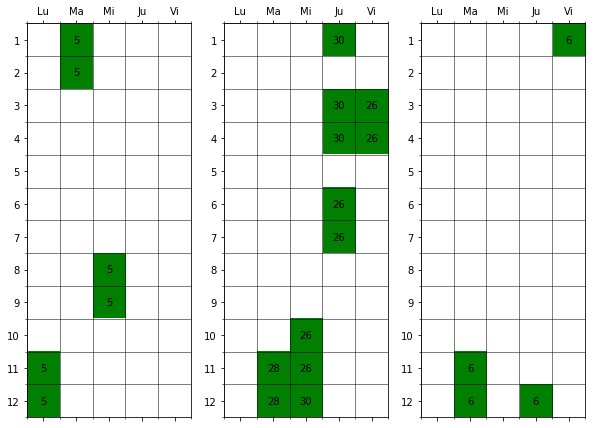

In [228]:
fig, axs = plt.subplots(1, 3, figsize=(10, 20))
fig.subplots_adjust(hspace = .5, wspace=0.2)

for ax, alumno in zip(axs, rnd.choice(a_set, 3, replace=False)):
    aa = np.zeros((num_modulos))
    for c in c_set:
        if X[alumno][c].varValue:
            aa = aa + horarios[c]*c
    aa_array = np.array(aa).reshape((5, 12)).transpose().astype(int)

    # mostrar matriz:
    ax.matshow(aa_array, cmap=ListedColormap(['w', 'g']))
    
    # labels de cada curso:
    for x in range(0, aa_array.shape[0]):
        for y in range(0, aa_array.shape[1]):
            if aa_array[x, y] != 0:
                ax.text(y, x, aa_array[x, y], ha="center", va="center")
    
    # ticks mayores:
    ax.set_xticks(np.arange(0, 5, 1));
    ax.set_yticks(np.arange(0, 12, 1));

    # labels:
    dias = ['Lu', 'Ma', 'Mi', 'Ju', 'Vi']
    ax.set_xticklabels(dias)
    ax.set_yticklabels(np.arange(1, 13, 1));

    # ticks menores:
    ax.set_xticks(np.arange(-.5, 5, 1), minor=True);
    ax.set_yticks(np.arange(-.5, 12, 1), minor=True);
    
    ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)

plt.show()